# 09c: Demand/Load Forecasting — NO_5 (Bergen)

**Phase 3** — Machine learning demand forecasting using gradient boosted trees.

This notebook predicts **actual electricity load** (MW, hourly) for NO_5 (Bergen)
using weather, calendar, commodity, reservoir, and supply-side features.

**Target: `actual_load`** (MW from ENTSO-E)

Electricity demand has very strong patterns:
- **Daily cycle:** low at night, peaks at 08:00 and 18:00 (morning + evening routines)
- **Weekly cycle:** weekdays higher than weekends (industrial/commercial demand)
- **Seasonal cycle:** winter peaks (electric heating), summer troughs
- **Temperature dependence:** cold weather = more heating = higher load (dominant in Norway)

**Methods:**
1. Naive baseline (same hour last week)
2. XGBoost
3. LightGBM
4. CatBoost
5. Weighted ensemble (inverse-MAE)
6. Walk-forward validation (6-fold)
7. SHAP feature importance analysis
8. Yr weather forecast integration (forward-looking predictions)

**Data split:**
- Training: 2022-01-01 to 2024-12-31 (~26,280 hours)
- Validation: 2025-01-01 to 2025-06-30 (~4,344 hours)
- Cutoff: 2026-02-22

In [1]:
import sys
import logging
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

# Project imports
sys.path.insert(0, str(Path.cwd().parent))
from src.models.forecasters import NaiveForecaster
from src.models.train import (
    MLPriceForecaster,
    prepare_ml_features,
    walk_forward_validate,
    train_ensemble,
    forecast_with_yr,
)
from src.models.evaluate import compute_metrics, comparison_table, plot_forecast, plot_residuals

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)s %(levelname)s %(message)s")

%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 5)
plt.rcParams["figure.dpi"] = 100

ZONE = "NO_5"
TARGET_COL = "actual_load"
print(f"Forecasting target: {TARGET_COL} (MW) for {ZONE} (Bergen)")

Forecasting target: actual_load (MW) for NO_5 (Bergen)


In [2]:
# Load feature matrix
data_path = Path.cwd().parent / "data" / "processed" / "features_NO_5_2022-01-01_2026-01-01.parquet"
df = pd.read_parquet(data_path)
print(f"Loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Verify target exists
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {sorted(df.columns)}")

# Extract target
target = df[TARGET_COL]

# Truncate at 2026-02-22 (end of available verified data)
cutoff = pd.Timestamp("2026-02-22", tz="Europe/Oslo")
df = df[df.index <= cutoff]
target = target[target.index <= cutoff]
print(f"After truncation: {len(target):,} hours ({target.index.min()} to {target.index.max()})")

# Data quality check
print(f"\nData quality check for {TARGET_COL}:")
print(f"  Total hours: {len(target):,}")
print(f"  NaN count: {target.isna().sum()}")
print(f"  Negative values: {(target < 0).sum()}")
print(f"  Range: {target.min():.0f} to {target.max():.0f} MW")
print(f"  Mean: {target.mean():.0f} MW, Std: {target.std():.0f} MW")

# Year-by-year summary
print("\nYearly summary:")
for year in range(2022, 2026):
    mask = target.index.year == year
    yearly = target[mask].dropna()
    if len(yearly) > 0:
        print(f"  {year}: {len(yearly):>5,} hours, "
              f"mean={yearly.mean():.0f} MW, std={yearly.std():.0f}, "
              f"min={yearly.min():.0f}, max={yearly.max():.0f}")

Loaded: 35,065 rows x 63 columns
Date range: 2022-01-01 00:00:00+01:00 to 2026-01-01 00:00:00+01:00
After truncation: 35,065 hours (2022-01-01 00:00:00+01:00 to 2026-01-01 00:00:00+01:00)

Data quality check for actual_load:
  Total hours: 35,065
  NaN count: 0
  Negative values: 0
  Range: 912 to 4326 MW
  Mean: 1952 MW, Std: 304 MW

Yearly summary:
  2022: 8,760 hours, mean=1878 MW, std=289, min=1164, max=4326
  2023: 8,760 hours, mean=1863 MW, std=363, min=912, max=3009
  2024: 8,784 hours, mean=2099 MW, std=116, min=1865, max=3045
  2025: 8,760 hours, mean=1966 MW, std=327, min=953, max=3147


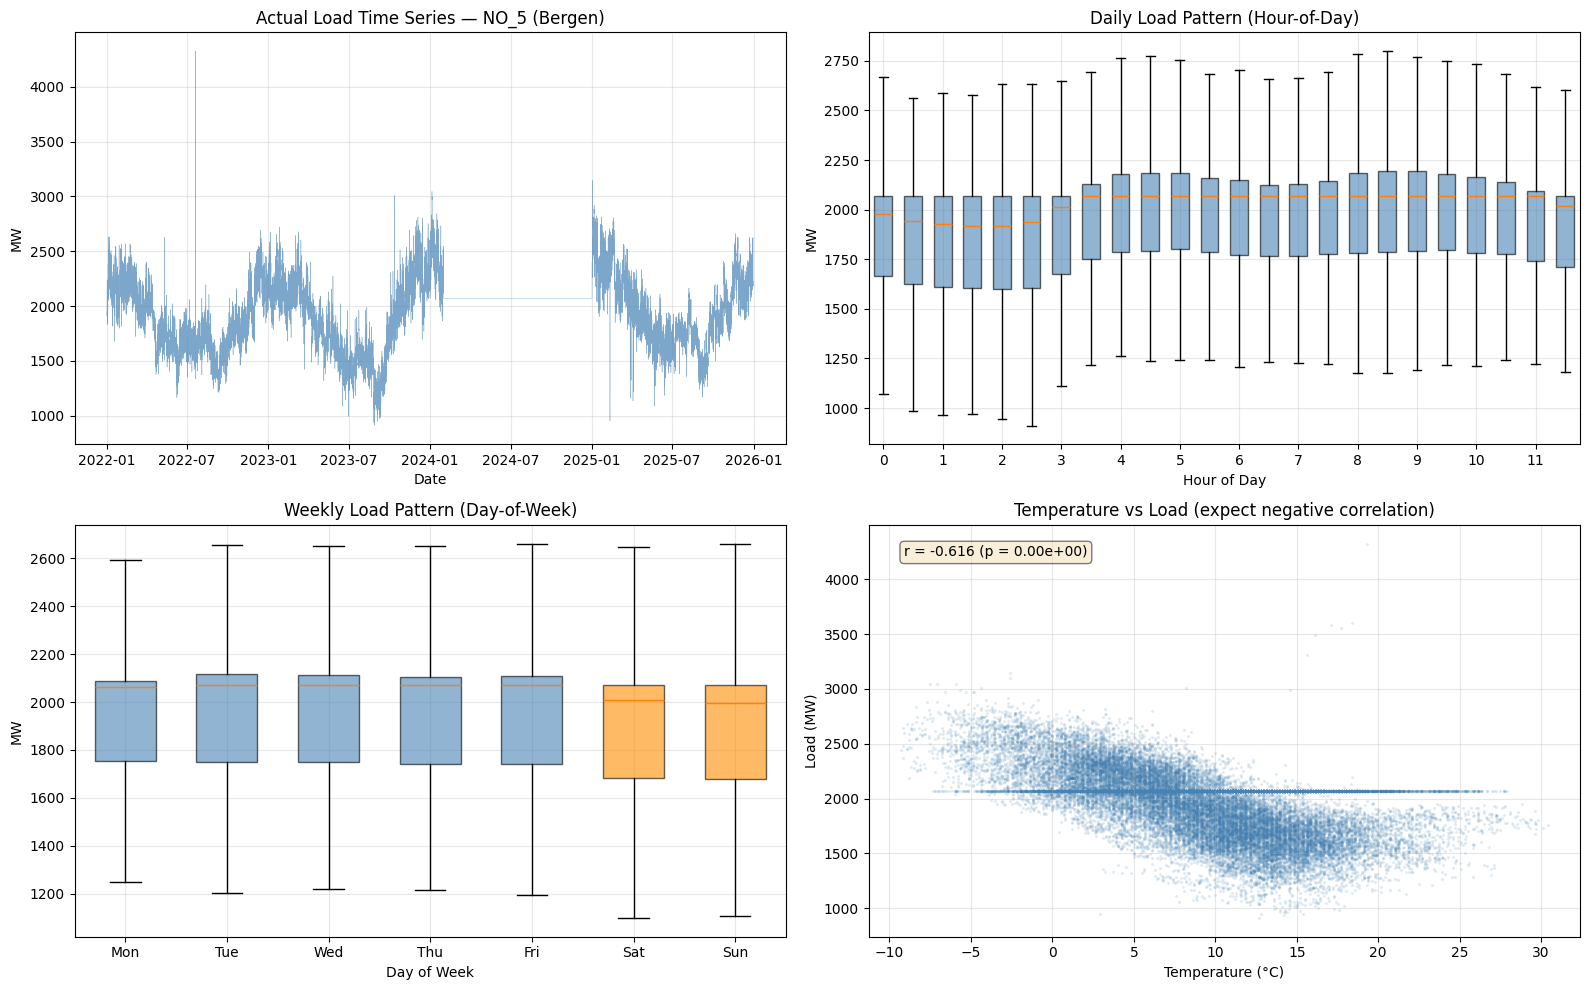

Load pattern summary:
  Peak hour (median): 7:00
  Trough hour (median): 4:00
  Weekday mean: 1968 MW
  Weekend mean: 1911 MW
  Weekend drop: 2.9%


In [3]:
# EDA: Load patterns
target_clean = target.dropna()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Full time series
ax = axes[0, 0]
ax.plot(target_clean.index, target_clean.values, linewidth=0.3, color="steelblue", alpha=0.7)
ax.set_xlabel("Date")
ax.set_ylabel("MW")
ax.set_title(f"Actual Load Time Series — {ZONE} (Bergen)")
ax.grid(True, alpha=0.3)

# 2. Hour-of-day boxplot (daily pattern)
ax = axes[0, 1]
hourly_data = [target_clean[target_clean.index.hour == h].values for h in range(24)]
bp = ax.boxplot(hourly_data, positions=range(24), widths=0.6,
                patch_artist=True, showfliers=False)
for patch in bp["boxes"]:
    patch.set_facecolor("steelblue")
    patch.set_alpha(0.6)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("MW")
ax.set_title("Daily Load Pattern (Hour-of-Day)")
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)

# 3. Day-of-week boxplot (weekly pattern)
ax = axes[1, 0]
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_data = [target_clean[target_clean.index.dayofweek == d].values for d in range(7)]
bp = ax.boxplot(dow_data, positions=range(7), widths=0.6,
                patch_artist=True, showfliers=False)
for i, patch in enumerate(bp["boxes"]):
    patch.set_facecolor("darkorange" if i >= 5 else "steelblue")
    patch.set_alpha(0.6)
ax.set_xlabel("Day of Week")
ax.set_ylabel("MW")
ax.set_title("Weekly Load Pattern (Day-of-Week)")
ax.set_xticks(range(7))
ax.set_xticklabels(dow_labels)
ax.grid(True, alpha=0.3)

# 4. Temperature vs Load scatter
ax = axes[1, 1]
if "temperature" in df.columns:
    temp_clean = df[["temperature", TARGET_COL]].dropna()
    ax.scatter(temp_clean["temperature"], temp_clean[TARGET_COL],
               alpha=0.1, s=2, color="steelblue")
    ax.set_xlabel("Temperature (\u00b0C)")
    ax.set_ylabel("Load (MW)")
    ax.set_title("Temperature vs Load (expect negative correlation)")
    # Add correlation
    r, p = stats.pearsonr(temp_clean["temperature"], temp_clean[TARGET_COL])
    ax.text(0.05, 0.95, f"r = {r:.3f} (p = {p:.2e})",
            transform=ax.transAxes, fontsize=10, verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
else:
    ax.text(0.5, 0.5, "Temperature data not available",
            transform=ax.transAxes, ha="center", va="center")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Load pattern summary:")
print(f"  Peak hour (median): {np.argmax([np.median(h) for h in hourly_data])}:00")
print(f"  Trough hour (median): {np.argmin([np.median(h) for h in hourly_data])}:00")
weekday_mean = target_clean[target_clean.index.dayofweek < 5].mean()
weekend_mean = target_clean[target_clean.index.dayofweek >= 5].mean()
print(f"  Weekday mean: {weekday_mean:.0f} MW")
print(f"  Weekend mean: {weekend_mean:.0f} MW")
print(f"  Weekend drop: {(1 - weekend_mean/weekday_mean)*100:.1f}%")

Training:   26,304 hours  (2022-01-01 to 2024-12-31)
Validation:  4,343 hours  (2025-01-01 to 2025-06-30)

Train mean: 1947 MW, std: 296
Val mean:   2029 MW, std: 351


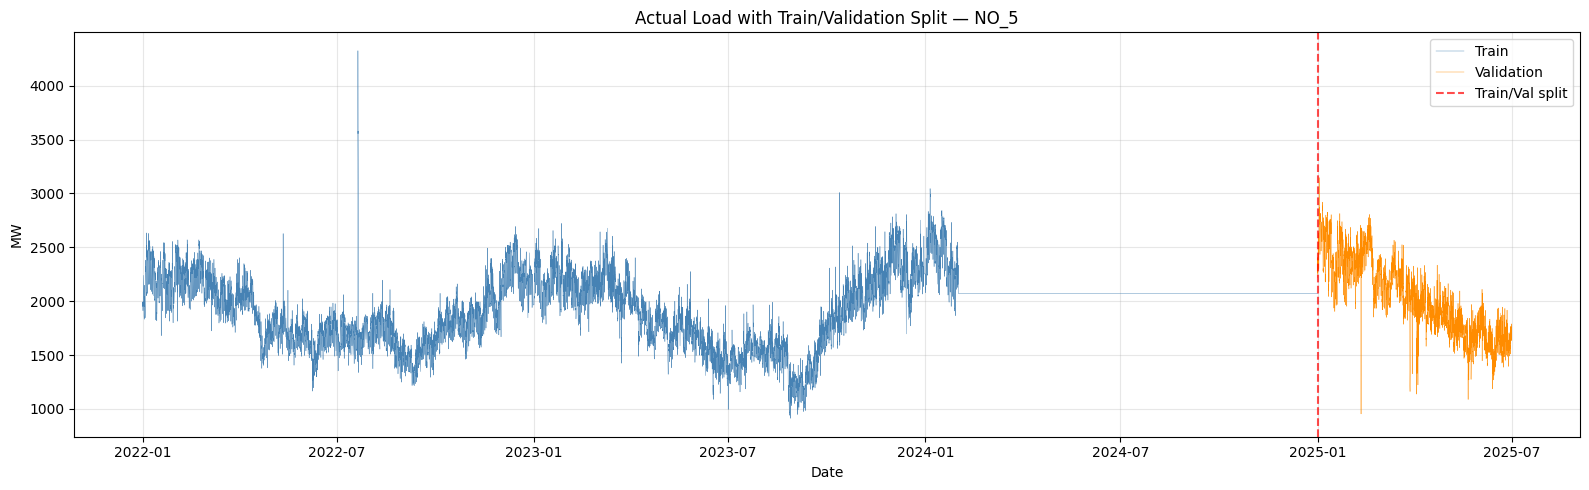

In [4]:
# Train / Validation split
TRAIN_END = pd.Timestamp("2024-12-31 23:00", tz="Europe/Oslo")
VAL_END = pd.Timestamp("2025-06-30 23:00", tz="Europe/Oslo")

y_train = target[target.index <= TRAIN_END]
y_val = target[(target.index > TRAIN_END) & (target.index <= VAL_END)]

df_train = df[df.index <= TRAIN_END]
df_val = df[(df.index > TRAIN_END) & (df.index <= VAL_END)]

print(f"Training:   {len(y_train):>6,} hours  ({y_train.index.min().date()} to {y_train.index.max().date()})")
print(f"Validation: {len(y_val):>6,} hours  ({y_val.index.min().date()} to {y_val.index.max().date()})")
print(f"\nTrain mean: {y_train.mean():.0f} MW, std: {y_train.std():.0f}")
print(f"Val mean:   {y_val.mean():.0f} MW, std: {y_val.std():.0f}")

# Visualize with split boundary
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(y_train.index, y_train, color="steelblue", linewidth=0.3, label="Train")
ax.plot(y_val.index, y_val, color="darkorange", linewidth=0.3, label="Validation")
ax.axvline(TRAIN_END, color="red", linestyle="--", alpha=0.7, label="Train/Val split")
ax.set_xlabel("Date")
ax.set_ylabel("MW")
ax.set_title(f"Actual Load with Train/Validation Split — {ZONE}")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Feature Preparation

**Leakage prevention is critical.** When predicting `actual_load`, we must drop any features
that are **derived from the target** itself:

| Feature | Why it leaks |
|---------|-------------|
| `load_lag_24h` | Derived from `actual_load` shifted 24 hours |
| `load_lag_168h` | Derived from `actual_load` shifted 168 hours |
| `load_rolling_24h_mean` | Rolling mean of `actual_load` |

These features are computed from the target variable. Including them would mean the model
is partially seeing the answer. We use `prepare_ml_features()` with explicit `drop_cols`
to remove them.

**What remains:** Calendar features (hour, day, month, weekend, holiday), weather
(temperature, wind, precipitation), commodities (gas, oil), reservoir levels,
generation data, Statnett flows, and FX rates.

In [5]:
# Prepare features with leakage prevention
# Drop load-derived features (computed from actual_load = our target)
LEAKAGE_COLS = ["load_lag_24h", "load_lag_168h", "load_rolling_24h_mean"]

X_train_full, y_train_full = prepare_ml_features(
    df_train, target_col=TARGET_COL, drop_cols=LEAKAGE_COLS
)
X_val_full, y_val_full = prepare_ml_features(
    df_val, target_col=TARGET_COL, drop_cols=LEAKAGE_COLS
)

print(f"Feature matrix: {X_train_full.shape[1]} features")
print(f"Training: {len(X_train_full):,} samples")
print(f"Validation: {len(X_val_full):,} samples")

# Verify leakage columns are gone
for col in LEAKAGE_COLS:
    assert col not in X_train_full.columns, f"Leakage column '{col}' still present!"
print(f"\nLeakage check passed: {LEAKAGE_COLS} all removed.")

# Group features by category
categories = {
    "Calendar": [c for c in X_train_full.columns if c in [
        "hour_of_day", "day_of_week", "month", "week_of_year",
        "is_weekend", "is_holiday", "is_business_hour"]],
    "Weather": [c for c in X_train_full.columns if c in [
        "temperature", "wind_speed", "precipitation",
        "temperature_lag_24h", "temperature_rolling_24h_mean"]],
    "Commodities": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["ttf_", "brent_", "coal_", "ng_"])],
    "Reservoir": [c for c in X_train_full.columns if "reservoir" in c],
    "FX": [c for c in X_train_full.columns if c == "eur_nok"],
    "Price": [c for c in X_train_full.columns if "price_eur" in c],
    "ENTSO-E (generation)": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["generation_", "hydro_", "wind_share",
                                   "total_net", "n_cables"])],
    "Internal Flows": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["flow_from_", "total_internal_",
                                   "net_internal_"])],
    "Statnett": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["net_exchange", "production_", "consumption_", "net_balance"])],
}

all_categorized = set()
for cols in categories.values():
    all_categorized.update(cols)
uncategorized = [c for c in X_train_full.columns if c not in all_categorized]
if uncategorized:
    categories["Other"] = uncategorized

print("\nFeatures by category:")
for cat, cols in categories.items():
    if cols:
        print(f"  {cat} ({len(cols)}): {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

2026-02-24 22:42:09,760 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:42:09,767 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:42:09,771 src.models.train INFO Prepared 26304 samples with 33 features (target: actual_load)
2026-02-24 22:42:09,773 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:42:09,773 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:42:09,774 src.models.train INFO Prepared 4343 samples with 33 features (target: actual_load)


Feature matrix: 33 features
Training: 26,304 samples
Validation: 4,343 samples

Leakage check passed: ['load_lag_24h', 'load_lag_168h', 'load_rolling_24h_mean'] all removed.

Features by category:
  Calendar (7): hour_of_day, day_of_week, month, week_of_year, is_weekend...
  Weather (5): temperature, wind_speed, precipitation, temperature_lag_24h, temperature_rolling_24h_mean
  Commodities (5): ttf_gas_close, brent_oil_close, coal_close, ng_fut_close, ttf_gas_change_7d
  Reservoir (5): reservoir_filling_pct, reservoir_filling_twh, reservoir_filling_change, reservoir_vs_median, reservoir_vs_min
  FX (1): eur_nok
  Price (1): price_eur_mwh
  ENTSO-E (generation) (5): generation_hydro, generation_wind, generation_total, hydro_share, wind_share
  Statnett (4): net_exchange_mwh, production_mwh, consumption_mwh, net_balance_mwh


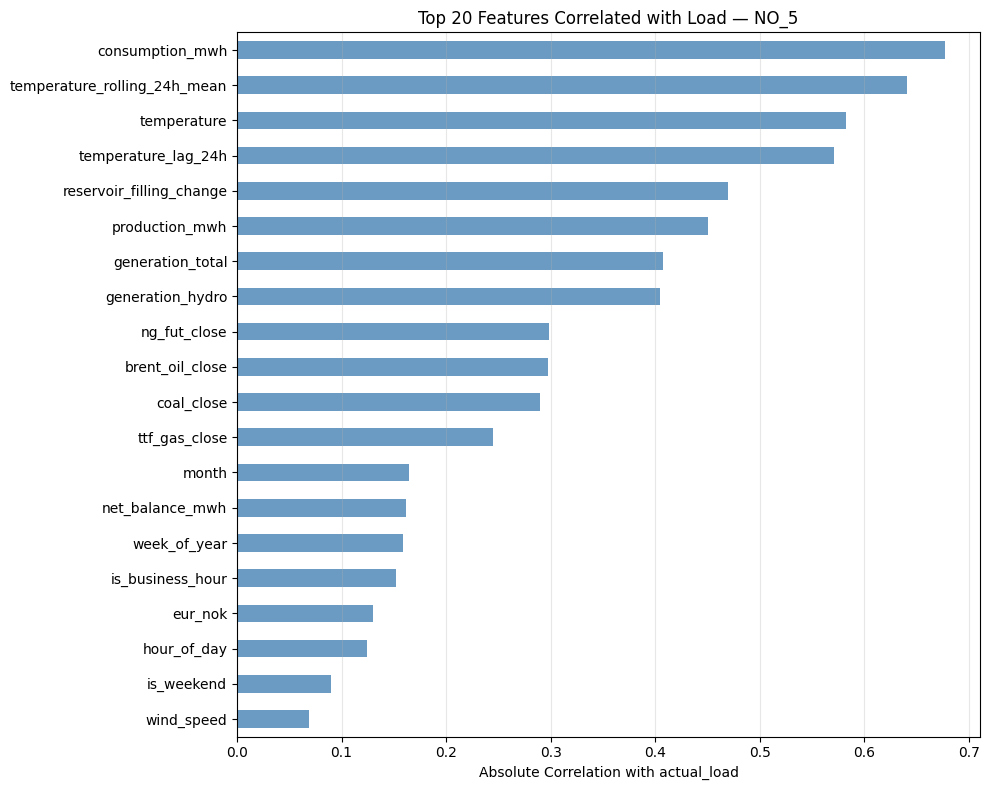

Top 10 correlated features:
  consumption_mwh: 0.677
  temperature_rolling_24h_mean: 0.641
  temperature: 0.583
  temperature_lag_24h: 0.571
  reservoir_filling_change: 0.470
  production_mwh: 0.450
  generation_total: 0.408
  generation_hydro: 0.404
  ng_fut_close: 0.298
  brent_oil_close: 0.297


In [6]:
# Correlation with target: top 20 features
corr_with_target = X_train_full.corrwith(y_train_full).abs().sort_values(ascending=False)
top_corr = corr_with_target.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
top_corr.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_xlabel(f"Absolute Correlation with {TARGET_COL}")
ax.set_title(f"Top 20 Features Correlated with Load — {ZONE}")
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("Top 10 correlated features:")
for feat, corr in top_corr.head(10).items():
    print(f"  {feat}: {corr:.3f}")

## 3. Naive Baseline

The simplest possible forecast: predict that each hour's load equals the same hour from **last week**.
This captures both daily and weekly patterns with zero modeling effort.

Load is more predictable than price (strong periodic patterns, no sudden market shocks),
so the naive baseline should already be decent. **Every model must beat this.**

In [7]:
# Collect results for all methods
all_results = []
all_forecasts = {}

# Naive baseline: same hour last week (lag=168)
naive = NaiveForecaster(name="Naive (same hour last week)", horizon=len(y_val), frequency="h", lag=168)
naive.fit(y_train)
naive_pred = naive.predict(steps=len(y_val))
naive_pred.index = y_val.index

naive_metrics = compute_metrics(y_val, naive_pred)
all_results.append({"name": "Naive (same hour last week)", "metrics": naive_metrics, "fit_time": naive.fit_time_seconds})
all_forecasts["Naive"] = naive_pred

print("Naive Baseline Results (MW):")
for k, v in naive_metrics.items():
    print(f"  {k}: {v}")

# Context: what does the MAE mean relative to load?
print(f"\nContext:")
print(f"  Mean load: {y_val.mean():.0f} MW")
print(f"  Naive MAE: {naive_metrics['mae']:.1f} MW ({naive_metrics['mae']/y_val.mean()*100:.1f}% of mean load)")

2026-02-24 22:42:09,866 src.models.forecasters INFO Naive (same hour last week) fit complete: 26304 samples in 0.0 seconds


Naive Baseline Results (MW):
  mae: 300.771
  rmse: 353.78
  mape: 15.68
  directional_accuracy: 0.0
  peak_hour_mae: 313.761

Context:
  Mean load: 2029 MW
  Naive MAE: 300.8 MW (14.8% of mean load)


## 4. ML Models

Load forecasting with gradient boosted trees. Demand has **stronger patterns** than price
(driven by temperature, calendar, and human behavior rather than market dynamics),
so we expect ML models to significantly outperform the naive baseline.

Key features we expect to dominate:
- `hour_of_day` — strong daily cycle
- `temperature` — cold weather = more heating = higher load
- `is_weekend` / `day_of_week` — weekday vs weekend effect
- `month` / `week_of_year` — seasonal heating demand

In [8]:
%%time

# XGBoost
xgb_model = MLPriceForecaster("xgboost")
xgb_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
xgb_pred = xgb_model.predict(X_val_full)

xgb_metrics = compute_metrics(y_val_full, xgb_pred, naive_pred=naive_pred)
all_results.append({"name": "XGBoost", "metrics": xgb_metrics, "fit_time": xgb_model.fit_time_seconds})
all_forecasts["XGBoost"] = xgb_pred

print(f"XGBoost Results (MW):")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {xgb_model.fit_time_seconds:.1f}s")
print(f"  vs Naive: {'BETTER' if xgb_metrics['mae'] < naive_metrics['mae'] else 'WORSE'} "
      f"(skill_score: {xgb_metrics.get('skill_score', 'N/A')})")

2026-02-24 22:42:10,583 src.models.train INFO xgboost fit: 26304 samples, 33 features in 0.5 s, best_iteration=156


XGBoost Results (MW):
  mae: 164.828
  rmse: 204.969
  mape: 7.79
  directional_accuracy: 64.9
  peak_hour_mae: 181.447
  skill_score: 0.452

  Fit time: 0.5s
  vs Naive: BETTER (skill_score: 0.452)
CPU times: user 1.09 s, sys: 717 ms, total: 1.8 s
Wall time: 688 ms


In [9]:
%%time

# LightGBM
lgbm_model = MLPriceForecaster("lightgbm")
lgbm_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
lgbm_pred = lgbm_model.predict(X_val_full)

lgbm_metrics = compute_metrics(y_val_full, lgbm_pred, naive_pred=naive_pred)
all_results.append({"name": "LightGBM", "metrics": lgbm_metrics, "fit_time": lgbm_model.fit_time_seconds})
all_forecasts["LightGBM"] = lgbm_pred

print(f"LightGBM Results (MW):")
for k, v in lgbm_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {lgbm_model.fit_time_seconds:.1f}s")
print(f"  vs XGBoost: {'BETTER' if lgbm_metrics['mae'] < xgb_metrics['mae'] else 'WORSE or EQUAL'} "
      f"({lgbm_model.fit_time_seconds:.1f}s vs {xgb_model.fit_time_seconds:.1f}s)")

2026-02-24 22:42:13,964 src.models.train INFO lightgbm fit: 26304 samples, 33 features in 3.3 s, best_iteration=270


LightGBM Results (MW):
  mae: 155.828
  rmse: 191.197
  mape: 7.51
  directional_accuracy: 65.7
  peak_hour_mae: 172.414
  skill_score: 0.482

  Fit time: 3.3s
  vs XGBoost: BETTER (3.3s vs 0.5s)
CPU times: user 2.62 s, sys: 7.61 s, total: 10.2 s
Wall time: 3.39 s


In [10]:
%%time

# CatBoost
cat_model = MLPriceForecaster("catboost")
cat_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
cat_pred = cat_model.predict(X_val_full)

cat_metrics = compute_metrics(y_val_full, cat_pred, naive_pred=naive_pred)
all_results.append({"name": "CatBoost", "metrics": cat_metrics, "fit_time": cat_model.fit_time_seconds})
all_forecasts["CatBoost"] = cat_pred

print(f"CatBoost Results (MW):")
for k, v in cat_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {cat_model.fit_time_seconds:.1f}s")

# Quick comparison
print(f"\nML model comparison (MAE in MW):")
print(f"  XGBoost:  {xgb_metrics['mae']:.1f}")
print(f"  LightGBM: {lgbm_metrics['mae']:.1f}")
print(f"  CatBoost: {cat_metrics['mae']:.1f}")
print(f"  Naive:    {naive_metrics['mae']:.1f}")

2026-02-24 22:42:14,333 src.models.train INFO catboost fit: 26304 samples, 33 features in 0.3 s, best_iteration=59


CatBoost Results (MW):
  mae: 162.83
  rmse: 216.427
  mape: 7.64
  directional_accuracy: 49.6
  peak_hour_mae: 184.108
  skill_score: 0.459

  Fit time: 0.3s

ML model comparison (MAE in MW):
  XGBoost:  164.8
  LightGBM: 155.8
  CatBoost: 162.8
  Naive:    300.8
CPU times: user 1.74 s, sys: 357 ms, total: 2.1 s
Wall time: 350 ms


In [11]:
# Ensemble: inverse-MAE weighted average
model_maes = {
    "xgboost": xgb_metrics["mae"],
    "lightgbm": lgbm_metrics["mae"],
    "catboost": cat_metrics["mae"],
}
inv_maes = {k: 1.0 / v for k, v in model_maes.items()}
total_inv = sum(inv_maes.values())
weights = {k: v / total_inv for k, v in inv_maes.items()}

print("Ensemble weights (inverse-MAE):")
for k, w in weights.items():
    print(f"  {k}: {w:.3f} (MAE: {model_maes[k]:.1f} MW)")

# Weighted ensemble
ensemble_pred = (
    weights["xgboost"] * xgb_pred
    + weights["lightgbm"] * lgbm_pred
    + weights["catboost"] * cat_pred
)
ensemble_pred.name = "Ensemble (weighted)"

ens_metrics = compute_metrics(y_val_full, ensemble_pred, naive_pred=naive_pred)
all_results.append({"name": "Ensemble (weighted)", "metrics": ens_metrics, "fit_time": 0})
all_forecasts["Ensemble"] = ensemble_pred

# Show all models comparison
comp = comparison_table(all_results)
print(f"\nAll models comparison (MAE in MW):")
display(comp)

# Context
best_mae = comp.iloc[0]["mae"]
print(f"\nBest model MAE: {best_mae:.1f} MW ({best_mae/y_val.mean()*100:.1f}% of mean load)")
print(f"Naive MAE: {naive_metrics['mae']:.1f} MW ({naive_metrics['mae']/y_val.mean()*100:.1f}% of mean load)")

Ensemble weights (inverse-MAE):
  xgboost: 0.326 (MAE: 164.8 MW)
  lightgbm: 0.345 (MAE: 155.8 MW)
  catboost: 0.330 (MAE: 162.8 MW)

All models comparison (MAE in MW):


,Method,mae,rmse,mape,directional_accuracy,peak_hour_mae,fit_time_s,skill_score
Rank,,,,,,,,
1,LightGBM,155.828,191.197,7.51,65.7,172.414,3.3,0.482
2,Ensemble (weighted),158.307,200.847,7.49,67.5,177.655,0.0,0.474
3,CatBoost,162.830,216.427,7.64,49.6,184.108,0.3,0.459
4,XGBoost,164.828,204.969,7.79,64.9,181.447,0.5,0.452
5,Naive (same hour last week),300.771,353.780,15.68,0.0,313.761,0.0,NaN



Best model MAE: 155.8 MW (7.7% of mean load)
Naive MAE: 300.8 MW (14.8% of mean load)


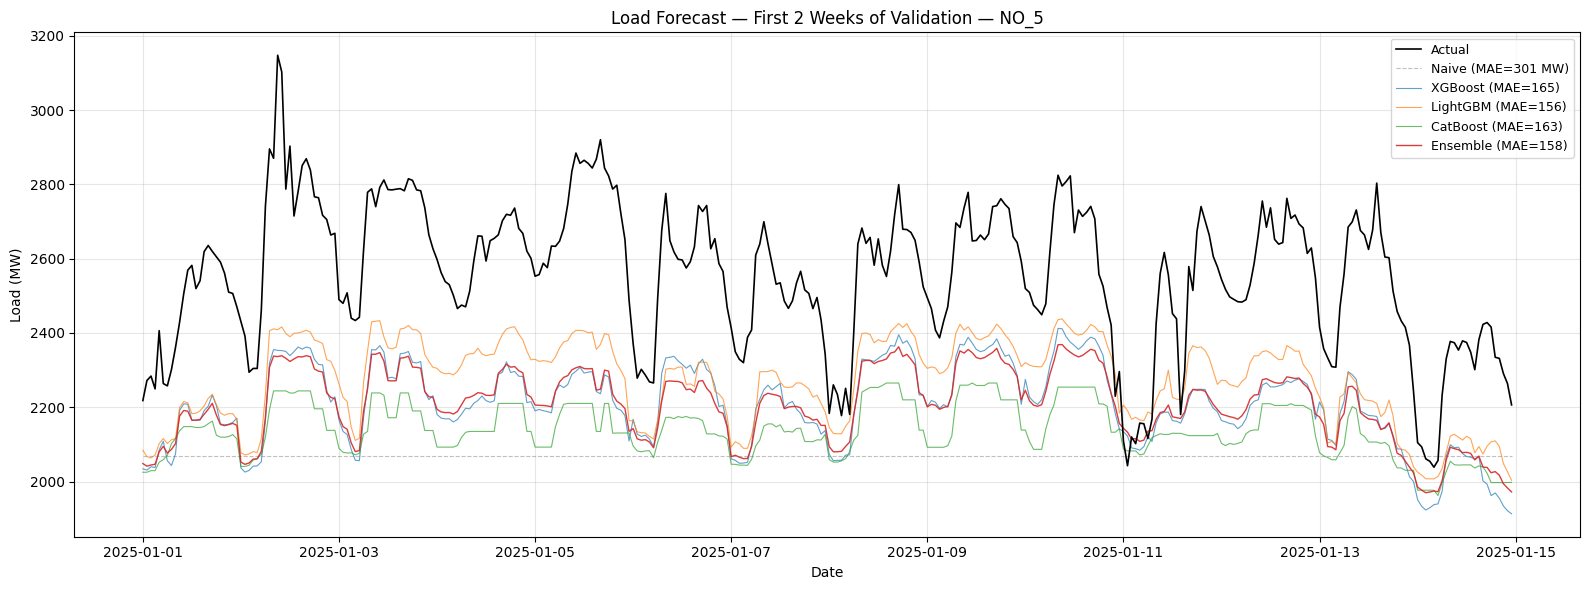

In [12]:
# Forecast overlay: first 2 weeks of validation
# Load has strong hourly patterns — 2 weeks shows both daily and weekly cycles
two_weeks = y_val_full.index[:336]  # 14 days x 24 hours

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(y_val_full.loc[two_weeks].index, y_val_full.loc[two_weeks],
        color="black", linewidth=1.2, label="Actual", zorder=5)
ax.plot(naive_pred.reindex(two_weeks).index, naive_pred.reindex(two_weeks),
        color="gray", linewidth=0.8, alpha=0.5, linestyle="--",
        label=f"Naive (MAE={naive_metrics['mae']:.0f} MW)")
ax.plot(xgb_pred.reindex(two_weeks).index, xgb_pred.reindex(two_weeks),
        color="tab:blue", linewidth=0.8, alpha=0.7,
        label=f"XGBoost (MAE={xgb_metrics['mae']:.0f})")
ax.plot(lgbm_pred.reindex(two_weeks).index, lgbm_pred.reindex(two_weeks),
        color="tab:orange", linewidth=0.8, alpha=0.7,
        label=f"LightGBM (MAE={lgbm_metrics['mae']:.0f})")
ax.plot(cat_pred.reindex(two_weeks).index, cat_pred.reindex(two_weeks),
        color="tab:green", linewidth=0.8, alpha=0.7,
        label=f"CatBoost (MAE={cat_metrics['mae']:.0f})")
ax.plot(ensemble_pred.reindex(two_weeks).index, ensemble_pred.reindex(two_weeks),
        color="tab:red", linewidth=1.0, alpha=0.9,
        label=f"Ensemble (MAE={ens_metrics['mae']:.0f})")

ax.set_xlabel("Date")
ax.set_ylabel("Load (MW)")
ax.set_title(f"Load Forecast — First 2 Weeks of Validation — {ZONE}")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Walk-Forward Validation

A single train/val split can be misleading — the model might work well in January but
poorly in May. Walk-forward validation simulates real deployment:

```
Fold 1: Train [2022-01 → 2025-01] | Val [2025-01 → 2025-02]
Fold 2: Train [2022-01 → 2025-02] | Val [2025-02 → 2025-03]
Fold 3: Train [2022-01 → 2025-03] | Val [2025-03 → 2025-04]
...expanding window, always predicting unseen future data
```

For load forecasting, we expect **seasonal variation** in accuracy: winter months (heating
demand volatility) may be harder to predict than stable summer months.

2026-02-24 22:42:14,468 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:42:14,472 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:42:14,474 src.models.train INFO Prepared 30647 samples with 36 features (target: actual_load)


Walk-forward validation using: lightgbm
Data: 30,647 hours
Target: actual_load
Configuration: 6 folds, ~720 hours (~1 month) each



2026-02-24 22:42:16,079 src.models.train INFO lightgbm fit: 26327 samples, 36 features in 1.6 s, best_iteration=93
2026-02-24 22:42:16,085 src.models.train INFO Fold 1/6: train=26327, val=720, MAE=136.15, fit=1.6s
2026-02-24 22:42:19,279 src.models.train INFO lightgbm fit: 27047 samples, 36 features in 3.2 s, best_iteration=252
2026-02-24 22:42:19,286 src.models.train INFO Fold 2/6: train=27047, val=720, MAE=53.10, fit=3.2s
2026-02-24 22:42:26,523 src.models.train INFO lightgbm fit: 27767 samples, 36 features in 7.2 s, best_iteration=669
2026-02-24 22:42:26,532 src.models.train INFO Fold 3/6: train=27767, val=720, MAE=60.79, fit=7.2s
2026-02-24 22:42:29,850 src.models.train INFO lightgbm fit: 28487 samples, 36 features in 3.3 s, best_iteration=262
2026-02-24 22:42:29,857 src.models.train INFO Fold 4/6: train=28487, val=720, MAE=60.06, fit=3.3s
2026-02-24 22:42:32,014 src.models.train INFO lightgbm fit: 29207 samples, 36 features in 2.1 s, best_iteration=148
2026-02-24 22:42:32,019 src.

,Fold,Train Size,Val Period,MAE (MW),RMSE (MW),Skill Score,Dir. Acc. (%),Fit Time (s)
0,1,"26,327",2025-01-01 to 2025-01-31,136.148,165.240,0.503,67.5,1.60
1,2,"27,047",2025-01-31 to 2025-03-02,53.105,87.031,0.688,76.5,3.19
2,3,"27,767",2025-03-02 to 2025-04-01,60.789,96.280,0.618,72.0,7.23
3,4,"28,487",2025-04-02 to 2025-05-01,60.063,92.202,0.587,61.5,3.31
4,5,"29,207",2025-05-02 to 2025-05-31,62.326,82.297,0.543,55.8,2.15
5,6,"29,927",2025-06-01 to 2025-06-30,53.194,71.895,0.612,60.2,2.76



Walk-forward MAE summary (MW):
  Mean: 70.9
  Std:  29.4
  Min:  53.1 (best fold)
  Max:  136.1 (worst fold)


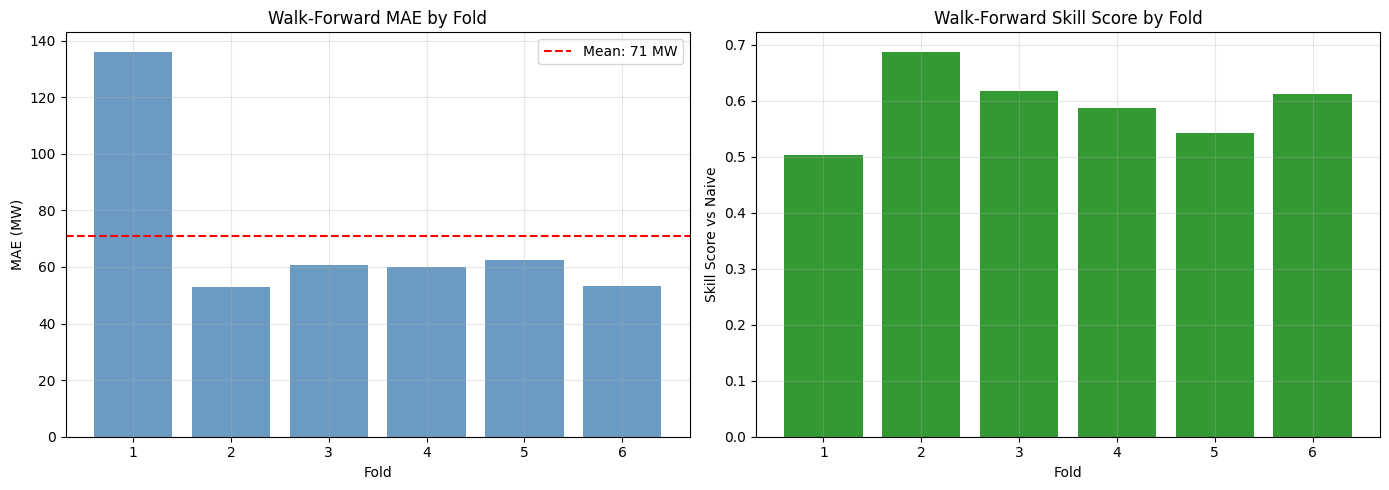

CPU times: user 15.7 s, sys: 45.6 s, total: 1min 1s
Wall time: 20.4 s


In [13]:
%%time

# Walk-forward validation with expanding window
df_walkforward = pd.concat([df_train, df_val])

# Use the best-performing individual model type
best_model_type = min(model_maes, key=model_maes.get)
print(f"Walk-forward validation using: {best_model_type}")
print(f"Data: {len(df_walkforward):,} hours")
print(f"Target: {TARGET_COL}")
print(f"Configuration: 6 folds, ~720 hours (~1 month) each\n")

wf_results = walk_forward_validate(
    df_walkforward,
    model_type=best_model_type,
    n_splits=6,
    val_size_hours=720,
    target_col=TARGET_COL,
)

# Per-fold metrics table
wf_rows = []
for r in wf_results:
    row = {
        "Fold": r["fold"],
        "Train Size": f"{r['train_size']:,}",
        "Val Period": f"{r['val_start'].strftime('%Y-%m-%d')} to {r['val_end'].strftime('%Y-%m-%d')}",
        "MAE (MW)": r["metrics"].get("mae", np.nan),
        "RMSE (MW)": r["metrics"].get("rmse", np.nan),
        "Skill Score": r["metrics"].get("skill_score", np.nan),
        "Dir. Acc. (%)": r["metrics"].get("directional_accuracy", np.nan),
        "Fit Time (s)": r["fit_time"],
    }
    wf_rows.append(row)

wf_df = pd.DataFrame(wf_rows)
display(wf_df)

# Summary
mae_values = [r["metrics"]["mae"] for r in wf_results if "mae" in r["metrics"]]
print(f"\nWalk-forward MAE summary (MW):")
print(f"  Mean: {np.mean(mae_values):.1f}")
print(f"  Std:  {np.std(mae_values):.1f}")
print(f"  Min:  {np.min(mae_values):.1f} (best fold)")
print(f"  Max:  {np.max(mae_values):.1f} (worst fold)")

# Stability chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE per fold
ax = axes[0]
folds = [r["fold"] for r in wf_results]
maes = [r["metrics"]["mae"] for r in wf_results]
ax.bar(folds, maes, color="steelblue", alpha=0.8)
ax.axhline(np.mean(maes), color="red", linestyle="--", label=f"Mean: {np.mean(maes):.0f} MW")
ax.set_xlabel("Fold")
ax.set_ylabel("MAE (MW)")
ax.set_title("Walk-Forward MAE by Fold")
ax.legend()
ax.grid(True, alpha=0.3)

# Skill score per fold
ax = axes[1]
skills = [r["metrics"].get("skill_score", 0) for r in wf_results]
colors = ["green" if s > 0 else "red" for s in skills]
ax.bar(folds, skills, color=colors, alpha=0.8)
ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Fold")
ax.set_ylabel("Skill Score vs Naive")
ax.set_title("Walk-Forward Skill Score by Fold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. SHAP Analysis

SHAP reveals **which features drive load predictions** and in which direction.
For demand forecasting, we expect:

- **`hour_of_day`** — dominant feature (strong daily cycle)
- **`temperature`** — cold = more heating = higher load (Norway is heating-dominated)
- **`is_weekend`** — weekends have lower industrial/commercial demand
- **`day_of_week`** — captures weekday variations
- **`month`** — seasonal pattern (winter heating vs summer)

If the model shows unexpected features as important, it may indicate data leakage or
a feature that is secretly correlated with load.

Computing SHAP values for XGBoost load model...
Using 4343 validation samples

SHAP values computed: (2000, 33)
Base value (expected prediction): 1947 MW


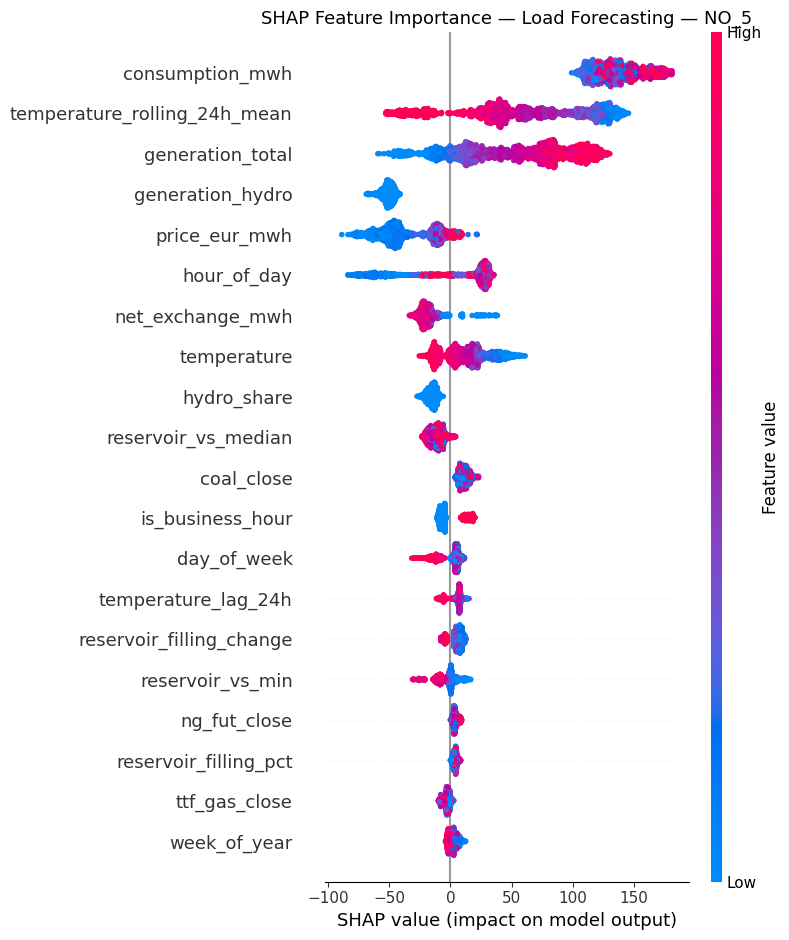


Top 10 features by mean |SHAP value| (MW):
  1. consumption_mwh: 135.9 MW
  2. temperature_rolling_24h_mean: 68.6 MW
  3. generation_total: 56.7 MW
  4. generation_hydro: 50.7 MW
  5. price_eur_mwh: 35.9 MW
  6. hour_of_day: 32.9 MW
  7. net_exchange_mwh: 19.4 MW
  8. temperature: 18.1 MW
  9. hydro_share: 15.2 MW
  10. reservoir_vs_median: 11.8 MW
CPU times: user 2.51 s, sys: 99.5 ms, total: 2.61 s
Wall time: 1.07 s


In [14]:
%%time

import shap

# Use XGBoost for SHAP (best native support)
print("Computing SHAP values for XGBoost load model...")
print(f"Using {len(X_val_full)} validation samples\n")

shap_sample_size = min(2000, len(X_val_full))
X_shap = X_val_full.ffill().bfill().fillna(0).iloc[:shap_sample_size]

explainer = shap.TreeExplainer(xgb_model.model_)
shap_values = explainer.shap_values(X_shap)

print(f"SHAP values computed: {shap_values.shape}")
print(f"Base value (expected prediction): {explainer.expected_value:.0f} MW")

# SHAP summary plot
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
plt.title(f"SHAP Feature Importance — Load Forecasting — {ZONE}", fontsize=13)
plt.tight_layout()
plt.show()

# Mean absolute SHAP values
mean_abs_shap = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=X_shap.columns,
).sort_values(ascending=False)

print("\nTop 10 features by mean |SHAP value| (MW):")
for i, (feat, val) in enumerate(mean_abs_shap.head(10).items(), 1):
    print(f"  {i}. {feat}: {val:.1f} MW")

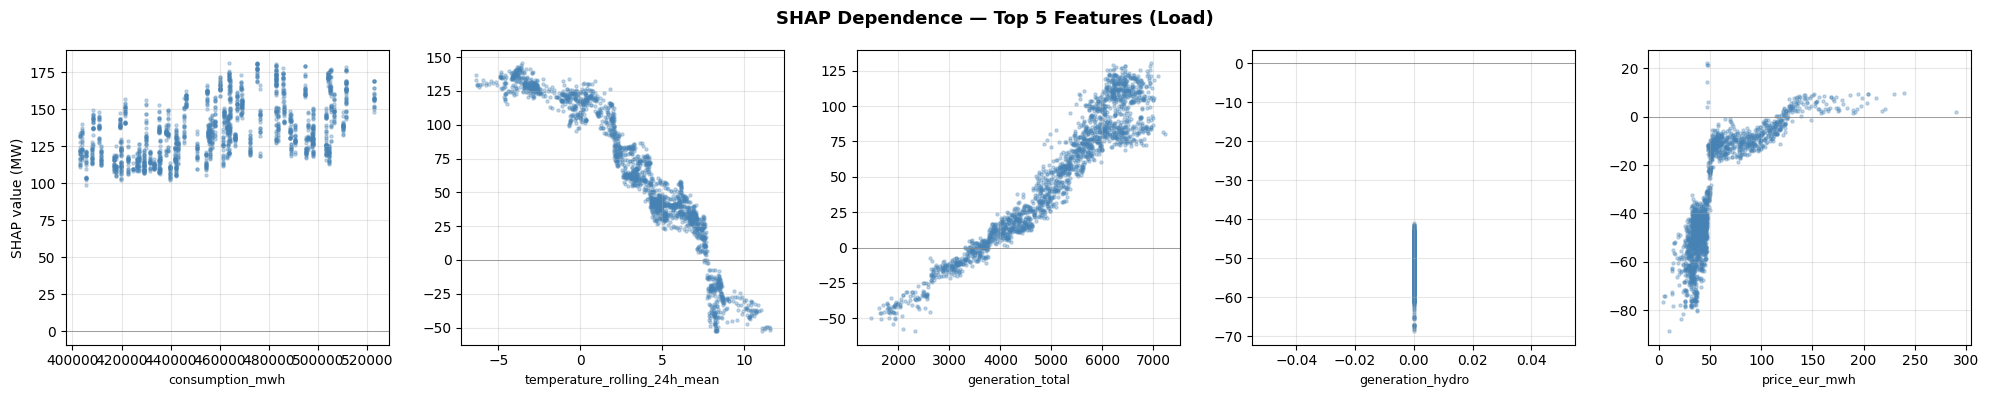

Expected patterns for load forecasting:
  - hour_of_day: U-shaped (high SHAP at 8am and 6pm, low at night)
  - temperature: negative relationship (cold -> more heating -> higher load)
  - is_weekend: negative SHAP when is_weekend=1 (lower demand on weekends)
  - month: seasonal pattern (high in winter months 11-2, low in summer 6-8)


In [15]:
# SHAP dependence plots for top 5 features
top_5_features = mean_abs_shap.head(5).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, feat in enumerate(top_5_features):
    ax = axes[i]
    feat_idx = list(X_shap.columns).index(feat)
    ax.scatter(X_shap[feat].values, shap_values[:, feat_idx],
               alpha=0.3, s=5, color="steelblue")
    ax.set_xlabel(feat, fontsize=9)
    ax.set_ylabel("SHAP value (MW)" if i == 0 else "")
    ax.axhline(0, color="gray", linewidth=0.5)
    ax.grid(True, alpha=0.3)

fig.suptitle("SHAP Dependence — Top 5 Features (Load)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# Interpretation
print("Expected patterns for load forecasting:")
print("  - hour_of_day: U-shaped (high SHAP at 8am and 6pm, low at night)")
print("  - temperature: negative relationship (cold -> more heating -> higher load)")
print("  - is_weekend: negative SHAP when is_weekend=1 (lower demand on weekends)")
print("  - month: seasonal pattern (high in winter months 11-2, low in summer 6-8)")

## 7. Forward Forecast

Generate a **forward-looking load forecast** using Yr weather forecasts (~9 days ahead).

The approach:
1. Fetch Yr Locationforecast for Bergen (temperature, wind, precipitation)
2. Build a feature matrix for the forecast horizon (calendar features computed, weather from Yr, other features forward-filled from last known values)
3. Predict with the best model
4. Aggregate to daily (mean / min / max) for a clear summary

Load forecasts are operationally valuable for grid operators and energy trading.

In [16]:
from src.data.fetch_yr_forecast import fetch_yr_forecast
import holidays as holidays_lib

# Fetch Yr weather forecast for Bergen (NO_5)
yr_df = fetch_yr_forecast(ZONE, cache=True)

if not yr_df.empty:
    print(f"Yr forecast for {ZONE}: {len(yr_df)} hours")
    print(f"  Range: {yr_df.index.min()} to {yr_df.index.max()}")

    # --- Build feature matrix inline for load prediction ---
    # Use the best individual model
    best_ml_model = {"xgboost": xgb_model, "lightgbm": lgbm_model, "catboost": cat_model}[best_model_type]
    feature_cols = best_ml_model.feature_names_

    forecast_index = yr_df.index
    n_steps = len(forecast_index)

    # Start from last known feature values as a template
    last_features = df.iloc[-336:]  # 2 weeks of history for context
    template = last_features[feature_cols].iloc[-1:].copy()
    X_future = pd.DataFrame(
        np.tile(template.values, (n_steps, 1)),
        columns=feature_cols,
        index=forecast_index,
    )

    # Override calendar features
    no_hol = holidays_lib.Norway()
    cal_map = {
        "hour_of_day": forecast_index.hour,
        "day_of_week": forecast_index.dayofweek,
        "month": forecast_index.month,
        "week_of_year": forecast_index.isocalendar().week.values,
        "is_weekend": (forecast_index.dayofweek >= 5).astype(int),
        "is_holiday": pd.Series(
            [int(d in no_hol) for d in forecast_index.date],
            index=forecast_index,
        ),
        "is_business_hour": (
            (forecast_index.hour >= 8)
            & (forecast_index.hour <= 17)
            & (forecast_index.dayofweek < 5)
        ).astype(int),
    }
    for col, values in cal_map.items():
        if col in X_future.columns:
            X_future[col] = values

    # Override weather with Yr forecast
    yr_to_hist = {
        "yr_temperature": "temperature",
        "yr_wind_speed": "wind_speed",
        "yr_precipitation_1h": "precipitation",
        "yr_cloud_cover": "cloud_cover",
        "yr_humidity": "humidity",
        "yr_pressure": "pressure",
    }
    for yr_col, hist_col in yr_to_hist.items():
        if hist_col in X_future.columns and yr_col in yr_df.columns:
            X_future[hist_col] = yr_df[yr_col].reindex(forecast_index)

    # Predict load
    load_forecast = best_ml_model.predict(X_future)
    load_forecast_df = pd.DataFrame({
        "load_mw": load_forecast.values,
    }, index=forecast_index)

    # Aggregate to daily
    daily_load = load_forecast_df.resample("D").agg(
        load_mean=("load_mw", "mean"),
        load_min=("load_mw", "min"),
        load_max=("load_mw", "max"),
    )
    daily_load = daily_load[daily_load["load_mean"].notna()]

    print(f"\nForward load forecast: {n_steps} hours")
    print(f"  Mean: {load_forecast.mean():.0f} MW")
    print(f"  Min:  {load_forecast.min():.0f} MW")
    print(f"  Max:  {load_forecast.max():.0f} MW")

    # Daily bar chart
    fig = go.Figure()

    # Min-max range
    fig.add_trace(go.Scatter(
        x=daily_load.index, y=daily_load["load_max"],
        mode="lines", line=dict(width=0), showlegend=False, hoverinfo="skip",
    ))
    fig.add_trace(go.Scatter(
        x=daily_load.index, y=daily_load["load_min"],
        mode="lines", line=dict(width=0),
        fill="tonexty", fillcolor="rgba(70, 130, 180, 0.2)",
        name="Hourly min-max range", hoverinfo="skip",
    ))

    # Daily mean bars
    fig.add_trace(go.Bar(
        x=daily_load.index, y=daily_load["load_mean"],
        marker_color="steelblue",
        name="Daily mean load",
        text=[f"{v:.0f}" for v in daily_load["load_mean"]],
        textposition="outside",
        hovertemplate=(
            "%{x|%a %d %b}<br>"
            "Mean: %{y:.0f} MW<br>"
            "Min: %{customdata[0]:.0f} MW<br>"
            "Max: %{customdata[1]:.0f} MW<extra></extra>"
        ),
        customdata=daily_load[["load_min", "load_max"]].values,
    ))

    # Reference line: last known daily mean load
    # Use add_shape + add_annotation instead of add_hline with annotation_text
    # to avoid Plotly bug with timezone-aware Timestamps
    last_day_load = target.iloc[-24:].mean()
    fig.add_shape(
        type="line",
        x0=0, x1=1, xref="paper",
        y0=last_day_load, y1=last_day_load,
        line=dict(color="black", width=1, dash="dash"),
        opacity=0.5,
    )
    fig.add_annotation(
        x=0.0, xref="paper",
        y=last_day_load,
        text=f"Last known daily mean: {last_day_load:.0f} MW",
        showarrow=False,
        font=dict(size=10),
        xanchor="left",
        yanchor="bottom",
    )

    fig.update_layout(
        title=f"Daily Load Forecast — {ZONE} (Bergen) — {best_model_type.upper()} + Yr Weather",
        xaxis_title="Date",
        yaxis_title="Load (MW)",
        hovermode="x unified",
        height=500,
        showlegend=True,
        bargap=0.15,
    )
    fig.show()

    # Summary table
    print(f"\nDaily load forecast summary:")
    display(daily_load.round(0))

else:
    load_forecast_df = pd.DataFrame()
    daily_load = pd.DataFrame()
    print("Yr forecast fetch failed — forward forecast skipped.")

2026-02-24 22:42:36,253 src.data.fetch_yr_forecast INFO Using cached Yr forecast for NO_5 (Bergen (Florida)) — 47 min old


Yr forecast for NO_5: 239 hours
  Range: 2026-02-24 21:00:00+01:00 to 2026-03-06 19:00:00+01:00

Forward load forecast: 239 hours
  Mean: 2283 MW
  Min:  2162 MW
  Max:  2359 MW



Daily load forecast summary:


,load_mean,load_min,load_max
time,,,
2026-02-24 00:00:00+01:00,2294.0,2281.0,2310.0
2026-02-25 00:00:00+01:00,2297.0,2199.0,2359.0
2026-02-26 00:00:00+01:00,2290.0,2175.0,2353.0
2026-02-27 00:00:00+01:00,2280.0,2185.0,2334.0
2026-02-28 00:00:00+01:00,2265.0,2162.0,2326.0
2026-03-01 00:00:00+01:00,2259.0,2170.0,2315.0
2026-03-02 00:00:00+01:00,2277.0,2176.0,2330.0
2026-03-03 00:00:00+01:00,2281.0,2168.0,2336.0
2026-03-04 00:00:00+01:00,2292.0,2189.0,2348.0


## 8. Residual Analysis

Examining where the ensemble model makes errors. Good residuals should be:
- **Unbiased** — mean close to zero
- **No temporal structure** — errors look like white noise
- **No systematic patterns** by hour or month

For load forecasting, we might see:
- Higher errors during **morning/evening ramps** (sharp load changes)
- Higher errors in **winter months** (volatile heating demand)
- Lower errors at **night** (stable, predictable base load)

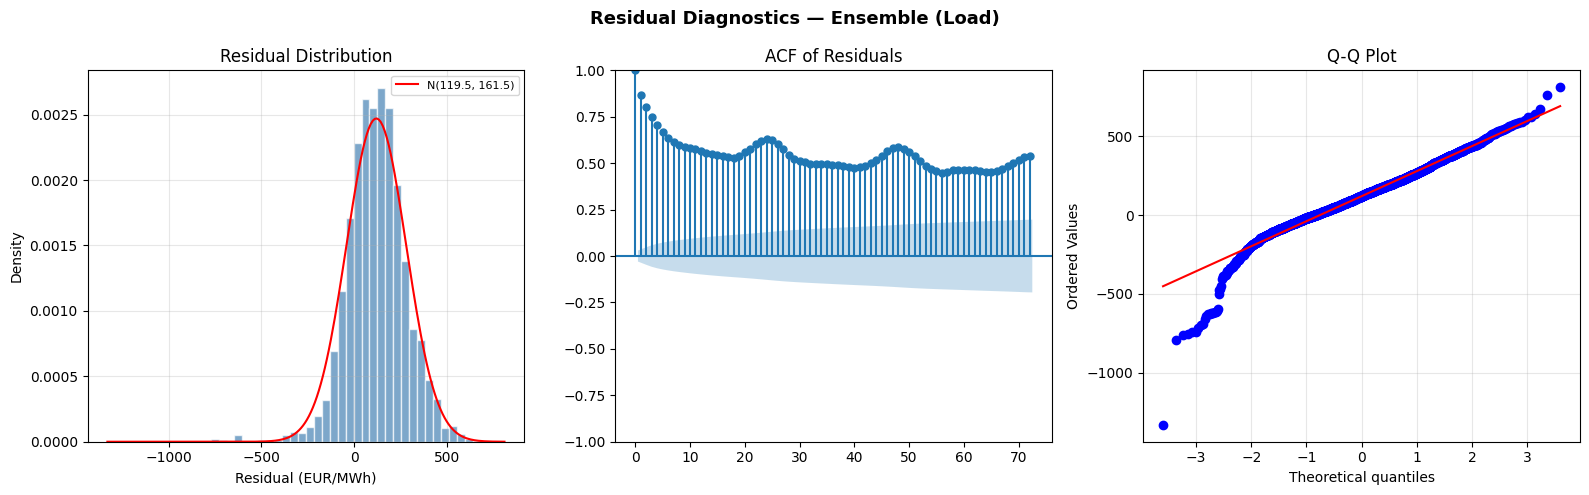

Shapiro-Wilk test: stat=0.9748, p=0.000000
Residuals do NOT appear normally distributed

Residual stats: mean=119.5 MW, std=161.5 MW
Skewness: -0.586, Kurtosis: 3.948


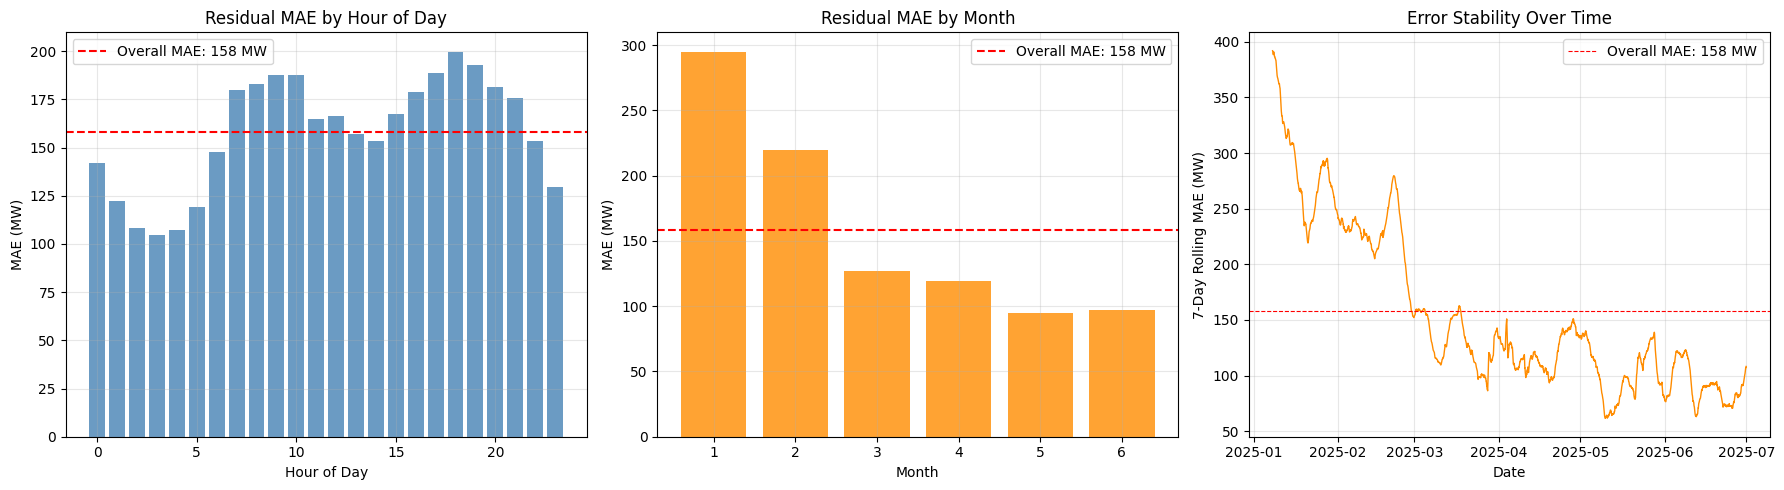


Hardest hours to predict (highest MAE):
  18:00 — MAE: 200 MW
  19:00 — MAE: 193 MW
  17:00 — MAE: 189 MW
  09:00 — MAE: 188 MW
  10:00 — MAE: 188 MW

Easiest hours to predict (lowest MAE):
  03:00 — MAE: 105 MW
  04:00 — MAE: 107 MW
  02:00 — MAE: 108 MW
  05:00 — MAE: 119 MW
  01:00 — MAE: 122 MW


In [17]:
# Residual diagnostics for the ensemble
residuals = (y_val_full - ensemble_pred).dropna()

# 3-panel diagnostic (histogram, ACF, QQ)
fig = plot_residuals(y_val_full, ensemble_pred, method_name="Ensemble (Load)")
plt.show()

# Shapiro-Wilk test
sample_resid = residuals.sample(min(2000, len(residuals)), random_state=42)
sw_stat, sw_p = stats.shapiro(sample_resid)
print(f"Shapiro-Wilk test: stat={sw_stat:.4f}, p={sw_p:.6f}")
print(f"Residuals {'appear' if sw_p > 0.05 else 'do NOT appear'} normally distributed")
print(f"\nResidual stats: mean={residuals.mean():.1f} MW, std={residuals.std():.1f} MW")
print(f"Skewness: {residuals.skew():.3f}, Kurtosis: {residuals.kurtosis():.3f}")

# --- By hour-of-day and month ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# By hour
ax = axes[0]
hourly_mae = residuals.abs().groupby(residuals.index.hour).mean()
ax.bar(hourly_mae.index, hourly_mae.values, color="steelblue", alpha=0.8)
ax.axhline(residuals.abs().mean(), color="red", linestyle="--",
           label=f"Overall MAE: {residuals.abs().mean():.0f} MW")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("MAE (MW)")
ax.set_title("Residual MAE by Hour of Day")
ax.legend()
ax.grid(True, alpha=0.3)

# By month
ax = axes[1]
monthly_mae = residuals.abs().groupby(residuals.index.month).mean()
ax.bar(monthly_mae.index, monthly_mae.values, color="darkorange", alpha=0.8)
ax.axhline(residuals.abs().mean(), color="red", linestyle="--",
           label=f"Overall MAE: {residuals.abs().mean():.0f} MW")
ax.set_xlabel("Month")
ax.set_ylabel("MAE (MW)")
ax.set_title("Residual MAE by Month")
ax.legend()
ax.grid(True, alpha=0.3)

# Rolling MAE (7-day window)
ax = axes[2]
rolling_mae = residuals.abs().rolling(168).mean()  # 7-day window
ax.plot(rolling_mae.index, rolling_mae, color="darkorange", linewidth=1)
ax.axhline(residuals.abs().mean(), color="red", linestyle="--", linewidth=0.8,
           label=f"Overall MAE: {residuals.abs().mean():.0f} MW")
ax.set_xlabel("Date")
ax.set_ylabel("7-Day Rolling MAE (MW)")
ax.set_title("Error Stability Over Time")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify worst hours
print(f"\nHardest hours to predict (highest MAE):")
worst_hours = hourly_mae.sort_values(ascending=False).head(5)
for hour, mae_val in worst_hours.items():
    print(f"  {hour:02d}:00 — MAE: {mae_val:.0f} MW")

print(f"\nEasiest hours to predict (lowest MAE):")
best_hours = hourly_mae.sort_values(ascending=True).head(5)
for hour, mae_val in best_hours.items():
    print(f"  {hour:02d}:00 — MAE: {mae_val:.0f} MW")

## 9. Key Findings

In [18]:
# Final summary
print("=" * 80)
print(f"DEMAND FORECASTING SUMMARY — {ZONE} (Bergen)")
print("=" * 80)

print(f"\nTarget: {TARGET_COL} (MW, hourly)")
print(f"Validation period: {y_val.index.min().date()} to {y_val.index.max().date()}")
print(f"Mean load: {y_val.mean():.0f} MW")
print(f"Features used: {X_train_full.shape[1]} (load lag features removed for leakage prevention)")

print(f"\n--- Final Rankings ---")
display(comp)

# Key numbers
best_method = comp.iloc[0]["Method"]
best_mae = comp.iloc[0]["mae"]
naive_mae = naive_metrics["mae"]

print(f"\n--- Key Results ---")
print(f"Best model: {best_method}")
print(f"  MAE: {best_mae:.1f} MW ({best_mae/y_val.mean()*100:.1f}% of mean load)")
print(f"  vs Naive ({naive_mae:.1f} MW): {(1 - best_mae/naive_mae)*100:.1f}% improvement")

print(f"\n--- Top Features (SHAP) ---")
for i, (feat, val) in enumerate(mean_abs_shap.head(5).items(), 1):
    print(f"  {i}. {feat} (SHAP: {val:.1f} MW)")

if not load_forecast_df.empty:
    print(f"\n--- Forward Forecast ---")
    print(f"  Horizon: {len(load_forecast_df)} hours "
          f"({load_forecast_df.index.min().date()} to {load_forecast_df.index.max().date()})")
    print(f"  Mean: {load_forecast_df['load_mw'].mean():.0f} MW")
    print(f"  Range: {load_forecast_df['load_mw'].min():.0f} – {load_forecast_df['load_mw'].max():.0f} MW")

print(f"\n--- Walk-Forward Validation ({best_model_type}) ---")
print(f"  {len(wf_results)} folds, MAE: {np.mean(mae_values):.0f} +/- {np.std(mae_values):.0f} MW")

print("\n" + "-" * 80)
print("Observations:")
print("-" * 80)
print("1. Load is more predictable than price — strong daily/weekly/seasonal patterns.")
print("2. Temperature is the dominant external driver (electric heating in Norway).")
print("3. Calendar features (hour, day, weekend) capture the predictable human behavior.")
print("4. Leakage prevention: load_lag_24h, load_lag_168h, load_rolling_24h_mean removed")
print("   because they are derived from the target variable itself.")
print("5. The ensemble combines three tree models for robust predictions.")
print("6. Yr weather forecasts enable forward-looking load predictions (~9 days).")
print("")
print("Next steps:")
print("- Use load forecasts as features for price prediction (demand drives price)")
print("- Production forecasting (09d) for the supply side")
print("- Multi-target integration (09f) combining demand + supply + price")

DEMAND FORECASTING SUMMARY — NO_5 (Bergen)

Target: actual_load (MW, hourly)
Validation period: 2025-01-01 to 2025-06-30
Mean load: 2029 MW
Features used: 33 (load lag features removed for leakage prevention)

--- Final Rankings ---


,Method,mae,rmse,mape,directional_accuracy,peak_hour_mae,fit_time_s,skill_score
Rank,,,,,,,,
1,LightGBM,155.828,191.197,7.51,65.7,172.414,3.3,0.482
2,Ensemble (weighted),158.307,200.847,7.49,67.5,177.655,0.0,0.474
3,CatBoost,162.830,216.427,7.64,49.6,184.108,0.3,0.459
4,XGBoost,164.828,204.969,7.79,64.9,181.447,0.5,0.452
5,Naive (same hour last week),300.771,353.780,15.68,0.0,313.761,0.0,NaN



--- Key Results ---
Best model: LightGBM
  MAE: 155.8 MW (7.7% of mean load)
  vs Naive (300.8 MW): 48.2% improvement

--- Top Features (SHAP) ---
  1. consumption_mwh (SHAP: 135.9 MW)
  2. temperature_rolling_24h_mean (SHAP: 68.6 MW)
  3. generation_total (SHAP: 56.7 MW)
  4. generation_hydro (SHAP: 50.7 MW)
  5. price_eur_mwh (SHAP: 35.9 MW)

--- Forward Forecast ---
  Horizon: 239 hours (2026-02-24 to 2026-03-06)
  Mean: 2283 MW
  Range: 2162 – 2359 MW

--- Walk-Forward Validation (lightgbm) ---
  6 folds, MAE: 71 +/- 29 MW

--------------------------------------------------------------------------------
Observations:
--------------------------------------------------------------------------------
1. Load is more predictable than price — strong daily/weekly/seasonal patterns.
2. Temperature is the dominant external driver (electric heating in Norway).
3. Calendar features (hour, day, weekend) capture the predictable human behavior.
4. Leakage prevention: load_lag_24h, load_lag_168h